### MRS - Movie Reccomentation System

In this notebook we are going to have a look at how we can create a recommendation system using AI. 


### Age of Recommendation System(RS)

Due to `IoT` data is now used to process and improve user experience. RS comes into play to improve user experience interms of quality of search results and reccomendation based on search terms and search history of the user.

RS are used to predict `ratings` or `preference` that the user would give to an item. Big tech companies are using these like:

1. Facebook
2. YouTube
3. Netflix
4. Amazon
5. etc.

In this notebook we are going to create some basic recommentation system, and show an example on how we can build an RS based on [tmdb-dataset](https://www.kaggle.com/tmdb/tmdb-movie-metadata). Before we do that let's have a look at different types of RS.

1. **Demographic Filtering**

* They offer generalized recommendations to every user, based on movie popularity and/or genre. 
* The System recommends the same movies to users with similar demographic features. 
* Although each user is different , this approach is considered to be too simple.
 * The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience. 

2. **Content Based Filtering**

* They suggest similar items based on a particular item. 
* This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. 
* The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.

3. **Collaborative Filtering**

* This system matches persons with similar interests and provides recommendations based on this matching.
 * Collaborative filters do not require item metadata like its content-based counterparts.


### Basic Imports

In the following code cell we are going to import all the packages that we are going to use throughout this notebook.

In [62]:
!pip install surprise  -q 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [65]:
import pandas as pd
import numpy as np
import random
import time
import os
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from ast import literal_eval
from surprise import Reader, Dataset, SVD
import surprise

from google.colab import drive, files

### File

The data that we are going to be using was downloaded at [kaggle](https://www.kaggle.com/tmdb/tmdb-movie-metadata) and was uploaded on google drive so that we can load them easily in this notebook. The files that we are going t have a look at are named:

1. `tmdb_5000_credits.csv`
2. `tmdb_5000_movies.csv`


So first we are going to mount the google drive by running the following command:



In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


Next we are going to define the file paths to where our files are located.

In [9]:
base_dir = '/content/drive/MyDrive/RECOMMENDATION SYSTEMS/TMDB-MOVIES'

movies_path = os.path.join(base_dir, 'tmdb_5000_movies.csv')
credits_path = os.path.join(base_dir, 'tmdb_5000_credits.csv')

assert os.path.exists(base_dir), f"The path {base_dir} does not exists."
assert os.path.exists(movies_path), f"The path {movies_path} does not exists."
assert os.path.exists(credits_path), f"The path {credits_path} does not exists."

The next thing is to read the movies together with the credits in data frames.

In [10]:
movies_df = pd.read_csv(movies_path)
credits_df = pd.read_csv(credits_path)

We then going to chech the first `5` rows in each dataframe.

1. `movies`

This dataframe contains the following features:

* `budget` - The budget in which the movie was made.
* `genre` - The genre of the movie, Action, Comedy ,Thriller etc.
* `homepage` - A link to the homepage of the movie.
* `id` - This is infact the movie_id as in the first dataset.
* `keywords` - The keywords or tags related to the movie.
* `original_language` - The language in which the movie was made.
* `original_title` - The title of the movie before translation or adaptation.
* `overview` - A brief description of the movie.
* `popularity` - A numeric quantity specifying the movie popularity.
* `production_companies` - The production house of the movie.
* `production_countries` - The country in which it was produced.
* `release_date` - The date on which it was released.
* `revenue` - The worldwide revenue generated by the movie.
* `runtime` - The running time of the movie in minutes.
* `status` - "Released" or "Rumored".
* `tagline` - Movie's tagline.
* `title` - Title of the movie.
* `vote_average` - average ratings the movie recieved.
* `vote_count` - the count of votes recieved.

In [12]:
movies_df.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124




2. `credits`

This dataframe contains the following feautures.


* `movie_id` - A unique identifier for each movie.
* `cast` - The name of lead and supporting actors.
* `crew` - The name of Director, Editor, Composer, Writer etc.


In [13]:
credits_df.head(5)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


Let's join this dataset by `id` and create a giant dataset as follows:


In [15]:
credits_df.columns = ['id','tittle','cast','crew']
dataframe = movies_df.merge(credits_df, on='id')

Now that our dataset is medged let's go ahead and check the first `5` rows in this dataset.

In [16]:
dataframe.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


Now that we have our medged dataframe we can start creating some recomendation algorithms.


### 1. Demographic Filtering

Before anything:

* we need a metric to score or rate movie
* Calculate the score for every movie
* Sort the scores and recommend the best rated movie to the users.

We can use the average ratings of the movie as the score but using this won't be fair enough since a movie with `8.9` average rating and only `3` votes cannot be considered better than the movie with `7.8` as as average rating but `40` votes. So, we'll be using IMDB's weighted rating `(wr)` which is given as :-

<p align="center">
<img src="https://image.ibb.co/jYWZp9/wr.png" alt="wr"/>
</p>

where:

* `v` - is the number of votes for the movie;
* `m` -  is the minimum votes required to be listed in the chart;
* `R` - is the average rating of the movie; And
* `C` - is the mean vote across the whole report

We already have `v(vote_count)` and `R (vote_average)` now we can calculate the value of `C` as follows:

In [17]:
C = dataframe.vote_average.mean()
print(f"C/mean: {C}")

C/mean: 6.092171559442016


So, the mean rating for all the movies is `~6`on a scale of 10.The next step is to determine an appropriate value for `m`, the minimum votes required to be listed in the chart. We will use `90th` percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least `90%` of the movies in the list.

In [18]:
m = dataframe.vote_count.quantile(0.9)
print(f"m/9th quantile: {m}")

m/9th quantile: 1838.4000000000015


Now, we can filter out the movies that qualify for the chart.

In [19]:
q_movies = dataframe.copy().loc[dataframe.vote_count >= m]
q_movies.shape

(481, 23)

We see that there are `481` movies which qualify to be in this list. Now, we need to calculate our metric for each qualified movie. To do this, we will define a function, called `weighted_rating()` and define a new feature score, of which we'll calculate the value by applying this function to our DataFrame of qualified movies:

In [20]:
def weighted_rating(dataframe, m=m, C=C):
  v = dataframe.vote_count
  R = dataframe.vote_average
  # Calculation based on the IMDB formula
  return (v/(v+m) * R) + (m/(m+v) * C)

Define a new feature `'score'` and calculate its value with `weighted_rating()`

In [21]:
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

Finally, let's sort the DataFrame based on the score feature and output the title, vote count, vote average and weighted rating or score of the top 10 movies.

In [22]:
q_movies = q_movies.sort_values('score', ascending=False)
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


Hurray! We have made our first(though very basic) recommender. Under the **Trending Now** tab of these systems we find movies that are very popular and they can just be obtained by sorting the dataset by the popularity column.

Text(0.5, 1.0, 'Popular Movies')

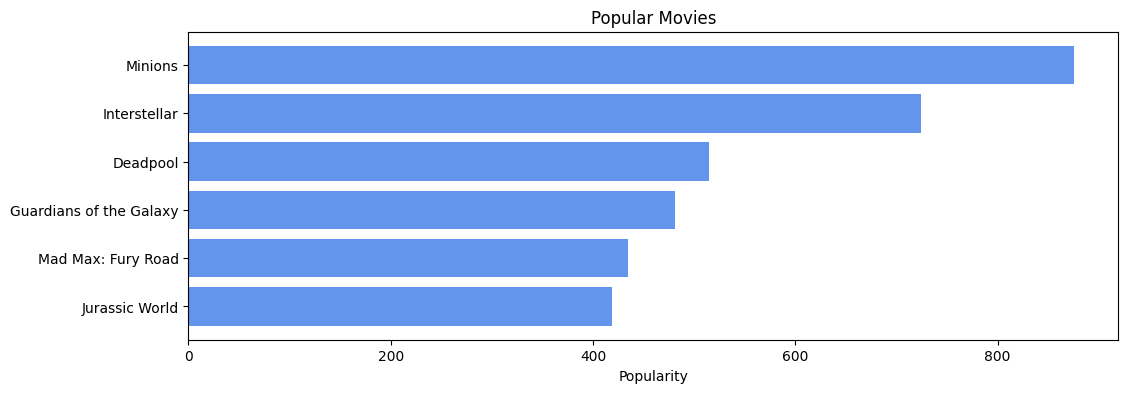

In [24]:
pop= dataframe.sort_values('popularity', ascending=False)
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='cornflowerblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

> Now something to keep in mind is that these **Demographic Recommender** provide a general chart of recommended movies to all the users. They are not sensitive to the interests and tastes of a particular user. This is when we move on to a more refined system - **Content Basesd Filtering**.


### Content Based Filtering

In this recommender system the content of the movie (overview, cast, crew, keyword, tagline etc) is used to find its similarity with other movies. Then the movies that are most likely to be similar are recommended.

<p align="center"><img src="https://image.ibb.co/f6mDXU/conten.png" alt="rm"/></p>

### Plot description based Recommender

We will compute pairwise similarity scores for all movies based on their plot descriptions and recommend movies based on that similarity score. The plot description is given in the `overview` feature of our dataset.

In [25]:
dataframe.overview.head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

We need to convert the word vector of each overview. Now we'll compute **`Term Frequency-Inverse Document Frequency`** ``(TF-IDF)`` vectors for each overview.

### What is term frequency?

it is the relative frequency of a word in a document and is given as (term instances/total instances). 

`Inverse Document Frequency` is the relative count of documents containing the term is given as $log(N/n)$ where:

* `N` - number of documents
* `n` - documents with term

The overall importance of each word to the documents in which they appear is equal to **`TF * IDF`**

This will give us a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each row represents a movie, as before.This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

> Fortunately, `scikit-learn` gives you a built-in `TfIdfVectorizer` class that produces the `TF-IDF` matrix in a couple of lines.

In [27]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf

TfidfVectorizer(stop_words='english')

Next we are going to replace the overviews of the movies that does not have overview with an empty string.

In [28]:
dataframe.overview = dataframe.overview.fillna('')

Next we are going to construct the required `TF-IDF` matrix by fitting and transforming the data

In [29]:
tfidf_matrix = tfidf.fit_transform(dataframe.overview)
tfidf_matrix.shape

(4803, 20978)

We see that over `20,000` different words were used to describe the `4800` movies in our dataset.

With this matrix in hand, we can now compute a similarity score. There are several candidates for this; such as the `euclidean`, the `Pearson` and the `cosine similarity` scores. There is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.

We will be using the `cosine similarity` to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:



<p align="center">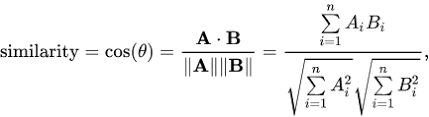</p>

Since we have used the **`TF-IDF`** vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's `linear_kernel()` instead of `cosine_similarities()` since it is faster.



In [31]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

We are going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices. In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.

In [36]:
indices = pd.Series(dataframe.index, index=dataframe['title']).drop_duplicates()
indices[:2]

title
Avatar                                      0
Pirates of the Caribbean: At World's End    1
dtype: int64

We are now in a good position to define our recommendation function. These are the following steps we'll follow :-

* Get the index of the movie given its title.
* Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
* Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
* Return the titles corresponding to the indices of the top elements.

In [37]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return dataframe['title'].iloc[movie_indices]

In [38]:
get_recommendations('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [39]:
get_recommendations('The Avengers')

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
Name: title, dtype: object

While our system has done a decent job of finding movies with similar plot descriptions, the quality of recommendations is not that great. "The Dark Knight Rises" returns all Batman movies while it is more likely that the people who liked that movie are more inclined to enjoy other Christopher Nolan movies. This is something that cannot be captured by the present system.

###Credits, Genres and Keywords Based Recommender
It goes without saying that the quality of our recommender would be increased with the usage of better `metadata`. That is exactly what we are going to do in this section. We are going to build a recommender based on the following `metadata`: the `3 top actors`, `the director`, `related genres` and the `movie plot keywords`.

From the cast, crew and keywords features, we need to extract the three most important actors, the director and the keywords associated with that movie. Right now, our data is present in the form of "stringified" lists , we need to convert it into a safe and usable structure

In [41]:

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
  dataframe[feature] = dataframe[feature].apply(literal_eval)

Next, we'll write functions that will help us to extract the required information from each feature.

In [43]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
  for i in x:
    if i['job'] == 'Director':
      return i['name']
  return np.nan

In [44]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [47]:
# Define new director, cast, genres and keywords features that are in a suitable form.
dataframe['director'] = dataframe['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    dataframe[feature] = dataframe[feature].apply(get_list)

In [48]:
# Print the new features of the first 3 films
dataframe[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.

In [49]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [50]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']
for feature in features:
    dataframe[feature] = dataframe[feature].apply(clean_data)

In [51]:
dataframe[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[samworthington, zoesaldana, sigourneyweaver]",jamescameron,"[cultureclash, future, spacewar]","[action, adventure, fantasy]"
1,Pirates of the Caribbean: At World's End,"[johnnydepp, orlandobloom, keiraknightley]",goreverbinski,"[ocean, drugabuse, exoticisland]","[adventure, fantasy, action]"
2,Spectre,"[danielcraig, christophwaltz, léaseydoux]",sammendes,"[spy, basedonnovel, secretagent]","[action, adventure, crime]"


We are now in a position to create our "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer (namely actors, director and keywords).

In [52]:
def create_soup(x):
  return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
  
dataframe['soup'] = dataframe.apply(create_soup, axis=1)

In [53]:
dataframe[['title', 'soup']].head(3)

,title,soup
0,Avatar,cultureclash future spacewar samworthington zo...
1,Pirates of the Caribbean: At World's End,ocean drugabuse exoticisland johnnydepp orland...
2,Spectre,spy basedonnovel secretagent danielcraig chris...


The next steps are the same as what we did with our plot description based recommender. One important difference is that we use the `CountVectorizer()` instead of `TF-IDF`. This is because we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense.

In [56]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(dataframe.soup)

In [57]:
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [58]:
dataframe = dataframe.reset_index()
indices = pd.Series(dataframe.index, index=dataframe.title)

We can now reuse our `get_recommendations()` function by passing in the new `cosine_sim2` matrix as your second argument.

In [59]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title, dtype: object

In [60]:
get_recommendations('The Godfather', cosine_sim2)

867      The Godfather: Part III
2731      The Godfather: Part II
4638    Amidst the Devil's Wings
2649           The Son of No One
1525              Apocalypse Now
1018             The Cotton Club
1170     The Talented Mr. Ripley
1209               The Rainmaker
1394               Donnie Brasco
1850                    Scarface
Name: title, dtype: object

 We see that our recommender has been successful in capturing more information due to more metadata and has given us (arguably) better recommendations. It is more likely that Marvels or DC comics fans will like the movies of the same production house. Therefore, to our features above we can add `production_company` . We can also increase the weight of the director , by adding the feature multiple times in the soup.

### Collaborative Filtering
Our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are **close** to a certain movie. That is, it is not capable of capturing tastes and providing recommendations **across genres**.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.

Therefore, in this section, we will use a technique called **`Collaborative Filtering`** to make recommendations to Movie Watchers. It is basically of two types:-

* `User based filtering`- These systems recommend products to a user that similar users have liked. For measuring the similarity between two users we can either use pearson correlation or cosine similarity. This filtering technique can be illustrated with an example. In the following matrixes, each row represents a user, while the columns correspond to different movies except the last one which records the similarity between that user and the target user. Each cell represents the rating that the user gives to that movie. Assume user `E ` is the target.

<p align="center"><img src="https://cdn-images-1.medium.com/max/1000/1*9NBFo4AUQABKfoUOpE3F8Q.png" alt="img"/></p>

Since user A and F do not share any movie ratings in common with user E, their similarities with user E are not defined in Pearson Correlation. Therefore, we only need to consider user B, C, and D. Based on Pearson Correlation, we can compute the following similarity.

<p align="center"><img src="https://cdn-images-1.medium.com/max/1000/1*jZIMJzKM1hKTFftHfcSxRw.png" alt="img"/></p>

From the above table we can see that user D is very different from user E as the Pearson Correlation between them is negative. He rated Me Before You higher than his rating average, while user E did the opposite. Now, we can start to fill in the blank for the movies that user E has not rated based on other users.

<p align="center"><img src="https://cdn-images-1.medium.com/max/1000/1*9TC6BrfxYttJwiATFAIFBg.png" alt="img"/></p>

Although computing user-based CF is very simple, it suffers from several problems. One main issue is that users’ preference can change over time. It indicates that precomputing the matrix based on their neighboring users may lead to bad performance. To tackle this problem, we can apply item-based CF.

* ``Item Based Collaborative Filtering`` - Instead of measuring the similarity between users, the item-based CF recommends items based on their similarity with the items that the target user rated. Likewise, the similarity can be computed with Pearson Correlation or Cosine Similarity. The major difference is that, with item-based collaborative filtering, we fill in the blank vertically, as oppose to the horizontal manner that user-based CF does. The following table shows how to do so for the movie Me Before You.

<p align="center"><img src="https://cdn-images-1.medium.com/max/1000/1*LqFnWb-cm92HoMYBL840Ew.png" alt="img"/></p>


It successfully avoids the problem posed by dynamic user preference as item-based CF is more static. However, several problems remain for this method. First, the main issue is `scalability`. The computation grows with both the customer and the product. The worst case complexity is O(mn) with m users and n items. In addition, `sparsity` is another concern. Take a look at the above table again. Although there is only one user that rated both Matrix and Titanic rated, the similarity between them is 1. In extreme cases, we can have millions of users and the similarity between two fairly different movies could be very high simply because they have similar rank for the only user who ranked them both.


### Single Value Decomposition
One way to handle the scalability and sparsity issue created by CF is to leverage a **latent factor model** to capture the similarity between users and items. Essentially, we want to turn the recommendation problem into an optimization problem. We can view it as how good we are in predicting the rating for items given a user. One common metric is Root Mean Square Error (RMSE). **The lower the RMSE**, the better the performance.

Now talking about latent factor you might be wondering what is it ?It is a broad idea which describes a property or concept that a user or an item have. For instance, for music, latent factor can refer to the genre that the music belongs to. SVD decreases the dimension of the utility matrix by extracting its latent factors. Essentially, we map each user and each item into a latent space with dimension r. Therefore, it helps us better understand the relationship between users and items as they become directly comparable. The below figure illustrates this idea.


<p align="center"><img src="https://cdn-images-1.medium.com/max/800/1*GUw90kG2ltTd2k_iv3Vo0Q.png" alt="img"/></p>

Now enough said , let's see how to implement this. Since the dataset we used before did not have userId(which is necessary for collaborative filtering) let's load another dataset. We'll be using the [Surprise](https://surprise.readthedocs.io/en/stable/index.html) library to implement SVD.

In [ ]:
reader = Reader()
ratings = pd.read_csv('../input/the-movies-dataset/ratings_small.csv')
ratings.head()

Note that in this dataset movies are rated on a scale of 5 unlike the earlier one.

In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
data.split(n_folds=5)

In [ ]:
svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

We get a mean Root Mean Sqaure Error of 0.89 approx which is more than good enough for our case. Let us now train on our dataset and arrive at predictions.

In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

Let us pick user with user Id 1 and check the ratings she/he has given.

In [ ]:
ratings[ratings['userId'] == 1]

svd.predict(1, 302, 3)

For movie with ID 302, we get an estimated prediction of 2.618. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

### Credits
All the credits to this awesome notebook that i got from `kaggle`.

1. [getting-started-with-a-movie-recommendation-system](https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system)


Other resources:

1. https://hackernoon.com/introduction-to-recommender-system-part-1-collaborative-filtering-singular-value-decomposition-44c9659c5e75
2. https://www.kaggle.com/rounakbanik/movie-recommender-systems
3. http://trouvus.com/wp-content/uploads/2016/03/A-hybrid-movie-recommender-system-based-on-neural-networks.pdf
